# MRR

## Imports

In [1]:
import timeit

from loguru import logger
from matplotlib import pyplot as plt
import numba as nb
import numpy as np
import pandas as pd


In [2]:
np.random.seed(23)

## Data

In [3]:
!mkdir ../data
!wget https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip -O ../data/data_original.zip
!unzip ../data/data_original.zip -d ../data

--2022-11-26 20:20:04--  https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78795385 (75M) [application/zip]
Saving to: ‘../data/data_original.zip’

../data/data_origin 100%[===================>]  75.14M  12.4MB/s    in 6.2s    

2022-11-26 20:20:12 (12.1 MB/s) - ‘../data/data_original.zip’ saved [78795385/78795385]

Archive:  ../data/data_original.zip
   creating: ../data/kion_train/
  inflating: ../data/kion_train/interactions.csv  
  inflating: ../data/__MACOSX/kion_train/._interactions.csv  
  inflating: ../data/kion_train/users.csv  
  inflating: ../data/__MACOSX/kion_train/._users.csv  
  inflating: ../data/kion_train/items.csv  
  inflating: ../data/__MACOSX/kion_train/._items.csv  


In [4]:
interactions = pd.read_csv('../data/kion_train/interactions.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    },
    inplace=True)

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [5]:
users = pd.read_csv('../data/kion_train/users.csv')
items = pd.read_csv('../data/kion_train/items.csv')

In [6]:
def generate_subsample(interactions, users_count, top_k):
    users = np.random.choice(interactions['user_id'].unique(), users_count, replace=False)
    df = interactions[interactions['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']

    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs

## Mrr calculation

In [7]:
def mrr_pandas(df_target: pd.DataFrame, users: np.ndarray, recs: np.ndarray):
    k = recs.shape[1]
    df_recs = pd.DataFrame({
        'user_id': np.repeat(users, k),
        'item_id': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df_recs = df_target.merge(df_recs, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
    df_recs['numerator'] = df_recs['rank'] < (k + 1)
    df_recs['reciprocal_rank'] = df_recs['numerator'] / df_recs['rank']
    df_recs['reciprocal_rank'] = df_recs['reciprocal_rank'].fillna(0)
    mrr = df_recs.groupby('user_id')['reciprocal_rank'].max().sum() / len(users)
    return mrr


def mrr_naive(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = []
    for i, user in enumerate(users):
        mrr_value = 0.0
        user_target = target[target[:, 0] == user][:, 1]
        for rank, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr_value += 1 / (rank + 1)
                break
        mrr.append(mrr_value)
    return sum(mrr) / len(users)


@nb.njit(cache=True, parallel=True)
def mrr_numba(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrr_value = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for rank, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr_value += 1 / (rank + 1)
                break
        mrr[i] = mrr_value
    return mrr.mean()


In [8]:
df, users, recs = generate_subsample(interactions=interactions, users_count=100, top_k=10)
target = df.values

In [9]:
mrp_p = mrr_pandas(df_target=df, users=users, recs=recs)
mrp_n = mrr_naive(target=target, users=users, recs=recs)
mrp_num = mrr_numba(target=target, users=np.array(users), recs=recs)
logger.info(f'mrr = {round(mrp_num, 7)}')
assert round(mrp_p, 7) == round(mrp_n, 7) == round(mrp_num, 7)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-11-26 20:23:44.490 | INFO     | __main__:<module>:4 - mrr = 0.0885873


In [10]:
users_counts = [100, 1000, 10000, 100000]
top_ks = [10, 50, 100]
n_iters = 10

time_naive = np.zeros((len(users_counts), len(top_ks)))
time_numba = np.zeros((len(users_counts), len(top_ks)))
time_pandas = np.zeros((len(users_counts), len(top_ks)))

## Compare speed naive, numba, pandas

In [11]:
for i, users_count in enumerate(users_counts):
    for j, top_k in enumerate(top_ks):
        logger.info(f'Num iters for each run {n_iters}')
        df, users, recs = generate_subsample(interactions=interactions, users_count=users_count, top_k=top_k)
        target = df.values

        logger.info(f'Naive user_count: {users_count}, top_k: {top_k}')
        t = timeit.timeit('mrr_naive(target, users, recs)', "from __main__ import mrr_naive, target, users, recs" , number=n_iters)
        logger.info(f'Avg time: {t / n_iters:0.5f} seconds')
        time_naive[i][j] = t / n_iters

        logger.info(f'Numba user_count: {users_count}, top_k: {top_k}')
        t = timeit.timeit('mrr_numba(target, users, recs)', "from __main__ import mrr_numba, target, users, recs", number=n_iters)
        logger.info(f'time: {t / n_iters:0.5f} seconds')
        time_numba[i][j] = t / n_iters

        logger.info(f'Pandas user_count: {users_count}, top_k: {top_k}')
        t = timeit.timeit('mrr_pandas(df, users, recs)', "from __main__ import mrr_pandas, df, users, recs", number=n_iters)
        logger.info(f'time: {t / n_iters:0.5f} seconds')
        time_pandas[i][j] = t / n_iters


2022-11-26 20:24:06.301 | INFO     | __main__:<module>:3 - Num iters for each run 10
2022-11-26 20:24:06.536 | INFO     | __main__:<module>:7 - Naive user_count: 100, top_k: 10
2022-11-26 20:24:06.577 | INFO     | __main__:<module>:9 - Avg time: 0.00398 seconds
2022-11-26 20:24:06.578 | INFO     | __main__:<module>:12 - Numba user_count: 100, top_k: 10
2022-11-26 20:24:06.583 | INFO     | __main__:<module>:14 - time: 0.00047 seconds
2022-11-26 20:24:06.584 | INFO     | __main__:<module>:17 - Pandas user_count: 100, top_k: 10
2022-11-26 20:24:06.634 | INFO     | __main__:<module>:19 - time: 0.00485 seconds
2022-11-26 20:24:06.635 | INFO     | __main__:<module>:3 - Num iters for each run 10
2022-11-26 20:24:06.823 | INFO     | __main__:<module>:7 - Naive user_count: 100, top_k: 50
2022-11-26 20:24:06.938 | INFO     | __main__:<module>:9 - Avg time: 0.01135 seconds
2022-11-26 20:24:06.938 | INFO     | __main__:<module>:12 - Numba user_count: 100, top_k: 50
2022-11-26 20:24:06.943 | INFO  

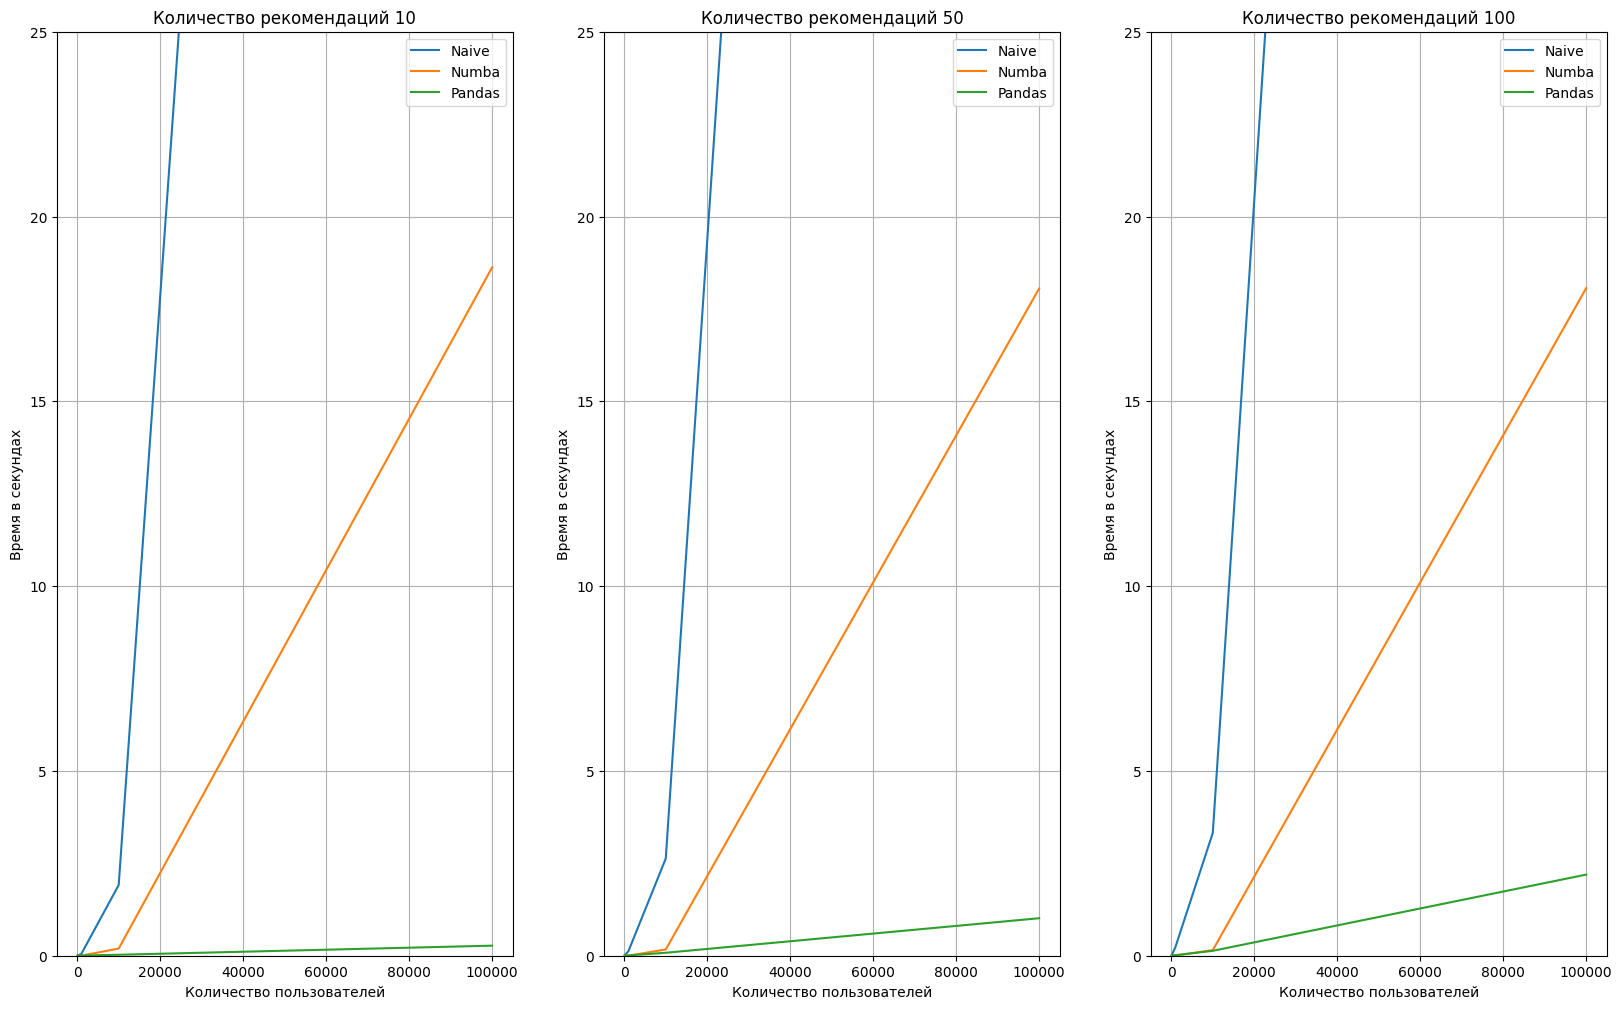

In [36]:
_, ax = plt.subplots(1, 3, figsize=(20, 12))
for i in range(3):
    ax[i].plot(users_counts, time_naive[:, i], label='Naive')
    ax[i].plot(users_counts, time_numba[:, i], label='Numba')
    ax[i].plot(users_counts, time_pandas[:, i], label='Pandas')
    ax[i].set_title(f'Количество рекомендаций {top_ks[i]}')
    ax[i].set_xlabel('Количество пользователей')
    ax[i].set_ylabel('Время в секундах')
    ax[i].set_ylim(0, 25)
    ax[i].grid()
    ax[i].legend()
plt.show()